In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt
import regex as reg
from sklearn.feature_extraction.text import CountVectorizer
import collections
from sklearn_pandas import DataFrameMapper
from collections import Counter

In [23]:
def dataPreProcessing(text):
    # Remove any characters that are not alphanumeric or spaces
    text = reg.sub('[^a-zA-Z0-9 ]', '', text)
    # Convert the text to lowercase
    text = text.lower()
    return text


In [24]:
trainingDataFrame = pd.read_csv('./data/train.csv')
rawTrainingDf=trainingDataFrame.copy()
testingDataFrame = pd.read_csv('./data/test.csv')


In [25]:
title1PostPreProcessing=trainingDataFrame['title1_en'].apply(dataPreProcessing)
title2PostPreProcessing = trainingDataFrame['title2_en'].apply(dataPreProcessing)
trainingDataFrame['title1_en']=title1PostPreProcessing
trainingDataFrame['title2_en']=title2PostPreProcessing

title1PostPreProcessing=testingDataFrame['title1_en'].apply(dataPreProcessing)
title2PostPreProcessing = testingDataFrame['title2_en'].apply(dataPreProcessing)
testingDataFrame['title1_en']=title1PostPreProcessing
testingDataFrame['title2_en']=title2PostPreProcessing

In [26]:
ranking=trainingDataFrame['label'].value_counts().index
mapping={i:k for k,i in enumerate(ranking,0)}

trainingDataFrame['titlesCombined'] = trainingDataFrame['title1_en']+trainingDataFrame['title2_en']
trainingDataFrame['label'] = trainingDataFrame['label'].map(mapping)
testingDataFrame['titlesCombined'] = testingDataFrame['title1_en']+testingDataFrame['title2_en']


In [27]:
trainingDataFrame['label'].value_counts().index

Int64Index([0, 1, 2], dtype='int64')

In [28]:
trainingSplit, validationSplit = train_test_split(trainingDataFrame, test_size=0.35,stratify=trainingDataFrame['label'],random_state=5)

In [29]:
vectorizer = TfidfVectorizer(stop_words="english", strip_accents=None, lowercase=True, encoding='utf-8', min_df=3).fit(trainingSplit['titlesCombined'])

In [30]:
trainingData = vectorizer.fit_transform(trainingSplit['titlesCombined'])
print(trainingData)
trainingLabels = trainingSplit['label']

  (0, 23969)	0.23465205506342357
  (0, 5391)	0.16321969338163253
  (0, 31794)	0.19663275675774206
  (0, 10915)	0.3212902426549629
  (0, 28943)	0.3159979013568693
  (0, 5247)	0.21218942514513142
  (0, 22953)	0.3180149812026979
  (0, 34002)	0.2659547981967378
  (0, 33600)	0.2675129517639927
  (0, 23251)	0.2896757987642684
  (0, 28544)	0.31503343882241763
  (0, 27704)	0.3336527669671755
  (0, 9826)	0.1576028445450544
  (0, 31003)	0.26225414027594063
  (1, 31021)	0.19420863027306265
  (1, 11726)	0.24441589721478096
  (1, 30371)	0.24288019242643313
  (1, 37376)	0.36950572010852883
  (1, 16108)	0.1889557332237505
  (1, 1728)	0.31422393632617046
  (1, 17697)	0.4389301905986727
  (1, 25335)	0.1341311741419189
  (1, 23785)	0.2027070982041273
  (1, 28039)	0.263385487453539
  (1, 9919)	0.214944950111386
  :	:
  (166684, 23340)	0.0809332630843605
  (166684, 12948)	0.24564421956439206
  (166685, 9995)	0.3992610126725173
  (166685, 13902)	0.3488381880739792
  (166685, 9997)	0.3950677645239987
  (166

In [31]:
logisticRegressionModel = LogisticRegression(penalty="l1",solver="liblinear",multi_class="auto",max_iter=1000, C=1).fit(trainingData, trainingLabels)

In [32]:
logisticRegressionModel.score(trainingData, trainingLabels)

0.8089293106241039

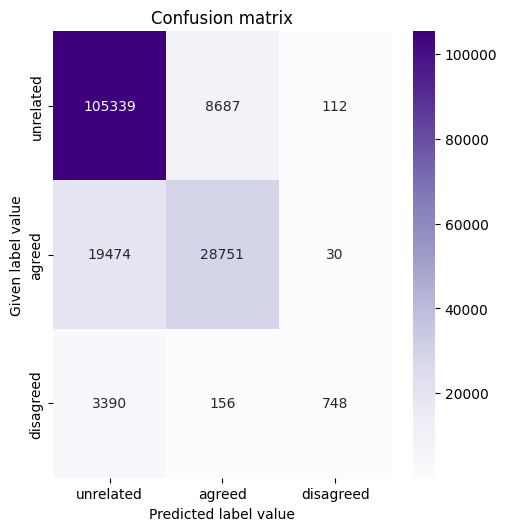

In [33]:
predictedLabels = logisticRegressionModel.predict(trainingData)
confusionMatrix = metrics.confusion_matrix(
    trainingLabels, predictedLabels)

classAttributes = ["unrelated", "agreed", "disagreed"]

plt.figure(figsize=(5,5))
tick_marks = np.arange(len(classAttributes))

sns.heatmap(pd.DataFrame(confusionMatrix), annot=True,
            cmap="Purples", fmt='g', xticklabels=classAttributes, yticklabels=classAttributes)
plt.tight_layout()
plt.ylabel('Given label value')
plt.xlabel('Predicted label value')
plt.title(
    'Confusion matrix')
plt.show()


In [34]:
print(predictedLabels)

[1 0 0 ... 1 0 0]


In [35]:
validData=vectorizer.transform(validationSplit['titlesCombined'])
validLabels=validationSplit['label']

In [36]:
logisticRegressionModel.score(validData, validLabels)

0.7830984346275973

In [37]:
predictedLabels=logisticRegressionModel.predict(validData)
predictedLabels

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [38]:
trainingDataFrame['label']

0         0
1         0
2         0
3         0
4         0
         ..
256437    0
256438    0
256439    0
256440    0
256441    0
Name: label, Length: 256442, dtype: int64

In [39]:
ranking=rawTrainingDf['label'].value_counts().index
mapping={k:i for k,i in enumerate(ranking,0)}

In [40]:
validLabelsCopy=validLabels.copy().map(mapping)
predictedLabelsCopy=pd.DataFrame({'predicted_values':predictedLabels})
predictedLabelsCopy['predicted_values']=predictedLabelsCopy['predicted_values'].map(mapping)

In [41]:
print(classification_report(validLabelsCopy, predictedLabelsCopy['predicted_values']))

              precision    recall  f1-score   support

      agreed       0.71      0.55      0.62     25983
   disagreed       0.75      0.14      0.23      2312
   unrelated       0.80      0.91      0.85     61460

    accuracy                           0.78     89755
   macro avg       0.76      0.53      0.57     89755
weighted avg       0.78      0.78      0.77     89755



In [42]:
final_test_data=vectorizer.transform(testingDataFrame['titlesCombined'])

In [43]:
testingDataFrame['label']=logisticRegressionModel.predict(final_test_data)

In [44]:
ranking=testingDataFrame['label'].value_counts().index
mapping={i:k for k,i in enumerate(ranking,0)}

testingDataFrame['label'] = testingDataFrame['label'].map(mapping)

In [45]:
testingDataFrame[['id','label']].to_csv("./data/submission.csv",index=False)